**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from examproject import simClass
import time
from types import SimpleNamespace
model = simClass()

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

initializing the model:
calling .setup()
calling .allocate()


## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $(1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

In [2]:
# a. define  as sympy symbols
alpha = sm.symbols('alpha')
kappa = sm.symbols('kappa')
nu = sm.symbols('nu')
w = sm.symbols('w')
tau = sm.symbols('tau')
C = sm.symbols('C')
G = sm.symbols('G')
L = sm.symbols('L')
wt = sm.symbols('wtilde')

# b. define utility and budget constraint
utility = sm.log(C**alpha*G**(1-alpha))-nu*(L**2/2)
budget_constraint = sm.Eq(kappa+wt*L,C)
budget_constraint_C = sm.solve(budget_constraint, C)

# c. substitute into utility and take derivative
utility_subs = utility.subs(C, budget_constraint_C[0])
foc = sm.diff(utility_subs, L)

# d. solve the FOC
sol = sm.solve(sm.Eq(foc,0), L)
sol_L = sol[1]

# e. difference to given solution
L_star = (-kappa+sm.sqrt(kappa**2+4*(alpha/nu)*wt**2))/(2*wt)
sol_func = sm.lambdify(args=(kappa,alpha,nu,wt),expr=L_star)
diff_L = sol_L-L_star

# f. compute numeric difference
diff_func = sm.lambdify(args=(kappa,alpha,nu,wt),expr=diff_L)
num_diff = diff_func(1.0,0.5,1/(2*16**2),(1-0.3)*1.0)
print(f'The difference between the given solution and the optimal solution we have found is: {num_diff:1.3f}')
print('Thus the given solution is the optimal choice')


The difference between the given solution and the optimal solution we have found is: 0.000
Thus the given solution is the optimal choice


**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

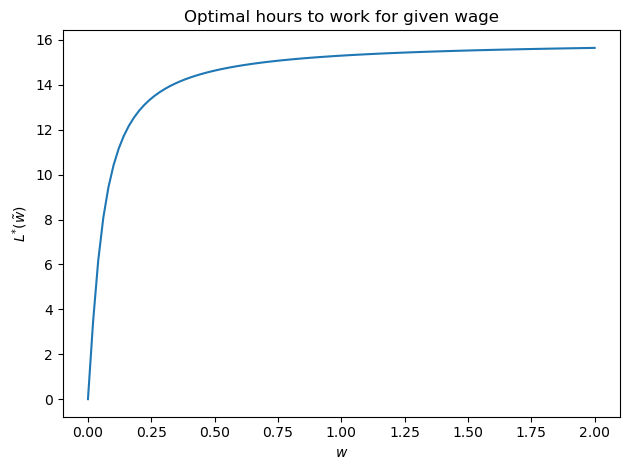

In [3]:
# a. create vectors for plot values
N = 100 # number of points to calculate
lower = 1e-8 # lower bound of w
upper = 2 # upper bound of w
w_vec = np.linspace(lower, upper, N)
L_vec = np.zeros(N)

# b. create function and set parameters
kappa = 1.0
alpha = 0.5
nu = 1/(2*16**2)
tau = 0.3

# c. calculate values
for i, w in enumerate(w_vec):
    wt = (1-tau)*w
    L_vec[i] = sol_func(kappa,alpha,nu,wt)

# d. plot figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,L_vec)

# e. labels and format
ax.set_xlabel('$w$') 
ax.set_ylabel(r'$L^{*}(\tilde{w})$')
plt.title('Optimal hours to work for given wage') 
fig.tight_layout()



We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


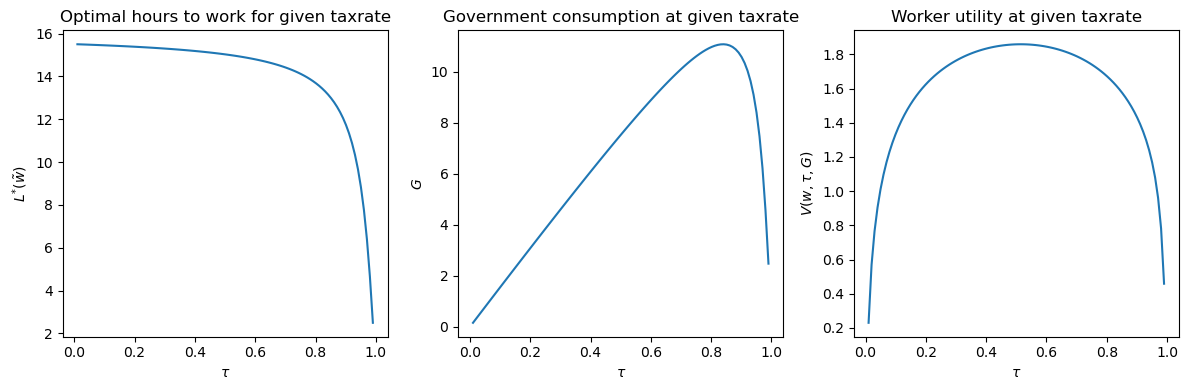

In [4]:
# a. create vectors for plot values
N = 100 # number of points to calculate
lower = 1e-2 # lower bound of tau
upper = 1.0-lower # upper bound of tau
tau_vec = np.linspace(lower, upper, N)
L_tau_vec = np.zeros(N)
G_tau_vec = np.zeros(N)
util_tau_vec = np.zeros(N)

# b. set parameters
kappa = 1.0
alpha = 0.5
nu = 1/(2*16**2)
w = 1.0

# c. calculate values
for i, tau in enumerate(tau_vec):
    tau = tau
    wt = (1-tau)*w
    L_tau_vec[i] = sol_func(kappa,alpha,nu,wt)
    G_tau_vec[i] = tau*w*L_tau_vec[i]
    util_tau_vec[i] = np.log((kappa+(1-tau)*w*L_tau_vec[i])**alpha*G_tau_vec[i]**(1-alpha))-nu*(L_tau_vec[i]**2/2)

# d. plot figures
fig = plt.figure(figsize=(12,4))

    # i. figure 1
ax = fig.add_subplot(1,3,1)
ax.plot(tau_vec,L_tau_vec)
ax.set_xlabel(r'$\tau$') 
ax.set_ylabel(r'$L^{*}(\tilde{w})$')
plt.title('Optimal hours to work for given taxrate')

    # ii. figure 2
ax = fig.add_subplot(1,3,2)
ax.plot(tau_vec,G_tau_vec)
ax.set_xlabel(r'$\tau$') 
ax.set_ylabel('$G$')
plt.title('Government consumption at given taxrate')

    # iii figure 3
ax = fig.add_subplot(1,3,3)
ax.plot(tau_vec,util_tau_vec)
ax.set_xlabel(r'$\tau$') 
ax.set_ylabel(r'$V(w,\tau,G)$')
plt.title('Worker utility at given taxrate')
fig.tight_layout() 

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

In [5]:
# a. set parameters
kappa = 1.0
alpha = 0.5
nu = 1/(2*16**2)
w = 1.0
lower = 1e-2 # lower bound of tau
upper = 1.0-lower # upper bound of tau
tau_0 = 0.5 # initial guess

# b. define negative utility dependant on tau
def negative_utility(tau):
    if tau>upper:
        neg_util=1
    elif tau<lower:
        neg_util=1
    else:
        wt = (1-tau)*w
        L = (-kappa+np.sqrt(kappa**2+4*(alpha/nu)*wt**2))/(2*wt)
        C = kappa + (1-tau)*w*L
        G = tau*w*L
        neg_util = -(np.log(C**alpha*G**(1-alpha))-nu*(L**2/2))
    return neg_util

# c. minimize negative utility
solution = optimize.minimize(negative_utility, tau_0, method='Nelder-Mead')

print(f'The socially optimal taxrate maximizing worker utility is: {solution.x[0]:1.3f}')
print(f'At this taxrate the worker utility is then: {-solution.fun:1.3f}')

The socially optimal taxrate maximizing worker utility is: 0.515
At this taxrate the worker utility is then: 1.859


Plotting worker utility focused around optimal taxrate

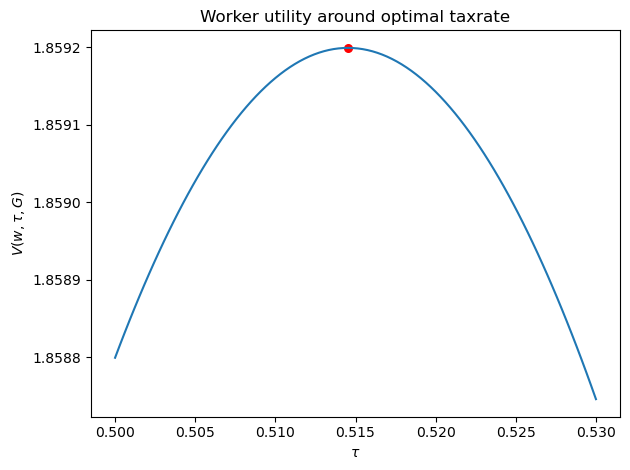

In [6]:
# a. setup
N = 100 # number of points to calculate
lower = 0.50 # lower bound of tau
upper = 0.53 # upper bound of tau
tau_opt_vec = np.linspace(lower, upper, N)
L_opt_vec = np.zeros(N)
G_opt_vec = np.zeros(N)
util_opt_vec = np.zeros(N)

# b. calculate utility
for i, tau in enumerate(tau_opt_vec):
    tau = tau
    wt = (1-tau)*w
    L_opt_vec[i] = sol_func(kappa,alpha,nu,wt)
    G_opt_vec[i] = tau*w*L_opt_vec[i]
    util_opt_vec[i] = np.log((kappa+(1-tau)*w*L_opt_vec[i])**alpha*G_opt_vec[i]**(1-alpha))-nu*(L_opt_vec[i]**2/2)

# c. plot figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(tau_opt_vec,util_opt_vec)
ax.scatter(solution.x[0],-solution.fun, c='red', s=30)
ax.set_xlabel(r'$\tau$') 
ax.set_ylabel(r'$V(w,\tau,G)$')
plt.title('Worker utility around optimal taxrate')
fig.tight_layout() 

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

In [7]:
# a. set parameters
sigma = 1.001  # set 1 value
rho = 1.01  # set 1 value
epsilon = 1.0
L_0 = 15  # initial guess

# b. define utility for given values of G and tau
def general_util_neg(L):
    C = kappa+(1-tau)*w*L
    G = tau*w*L
    util = -((((alpha*C**((sigma-1)/sigma)+(1-alpha)*G**((sigma-1)/sigma)) **
            (sigma/(sigma-1)))**(1-rho)-1)/(1-rho)-nu*(L**(1+epsilon)/(1+epsilon)))
    return util

# c. optimize given values of G and tau
tau = 0.5
sol_gvalues = optimize.minimize(general_util_neg, L_0, method='Nelder-Mead')

# d. optimize given tau from question 4 and set 1 parameters
tau = solution.x[0] # solution from Q4
sol_gtau_set1 = optimize.minimize(general_util_neg, L_0, method='Nelder-Mead')
G_set1 = tau*w*sol_gtau_set1.x[0]

# e. optimize given tau from question 4 and set 2 parameters
sigma = 1.5  # set 2 value
rho = 1.5  # set 2 value
tau = solution.x[0]
sol_gtau_set2 = optimize.minimize(general_util_neg, L_0, method='Nelder-Mead')
G_set2 = tau*w*sol_gtau_set2.x[0]

# f. print results
print(f'Given set 1 parameters and tau from question 4 we have the optimal L: {sol_gtau_set1.x[0]:1.3f} and thus G is then: {G_set1:1.3f}')
print(f'Then when parameters are equal to set 2 values we have optimal L: {sol_gtau_set2.x[0]:1.3f} with G equal to: {G_set2:1.3f}')


Given set 1 parameters and tau from question 4 we have the optimal L: 21.867 and thus G is then: 11.252
Then when parameters are equal to set 2 values we have optimal L: 13.351 with G equal to: 6.870


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

In [8]:
# a. define negative utility where tau and L can be adjusted
def neg_gen_ut(x):
    L, tau = x.ravel()
    C = kappa+(1-tau)*w*L
    G = tau*w*L
    util = -((((alpha*C**((sigma-1)/sigma)+(1-alpha)*G**((sigma-1)/sigma)) **
            (sigma/(sigma-1)))**(1-rho)-1)/(1-rho)-nu*(L**(1+epsilon)/(1+epsilon)))
    return util

# b. find optimal taxrate for set 1 parameters
sigma = 1.001  # set 1 value
rho = 1.01  # set 1 value
epsilon = 1.0
t_0 = 0.5  # initial guess
L_0 = 13 # initial guess
sol_set1 = optimize.minimize(neg_gen_ut, [L_0, tau_0], method='Nelder-Mead')

# c. find optimal taxrate for set 2 parameters
sigma = 1.5  # set 1 value
rho = 1.5  # set 1 value
t_0 = 0.5  # initial guess
L_0 = 13 # initial guess
sol_set2 = optimize.minimize(neg_gen_ut, [L_0, tau_0], method='Nelder-Mead')

# d. print solutions
print(f'Given set 1 parameter values the socially optimal taxrate is: {sol_set1.x[1]:1.3f} where the workers utility is {-sol_set1.fun:1.3f} and hours worked is {sol_set1.x[0]:1.3f}')
print(f'Then when given set 2 parameter values the socially optimal taxrate is: {sol_set2.x[1]:1.3f} where the workers utility is {-sol_set2.fun:1.3f} and hours worked is {sol_set2.x[0]:1.3f}')

Given set 1 parameter values the socially optimal taxrate is: 0.523 where the workers utility is 1.940 and hours worked is 21.859
Then when given set 2 parameter values the socially optimal taxrate is: 0.537 where the workers utility is 1.079 and hours worked is 13.338


## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each hairdresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [9]:
# a. misc setup
sol = SimpleNamespace()
opt = SimpleNamespace()
par = SimpleNamespace()
sim = SimpleNamespace()
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

In [10]:
# a. profits
profits = lambda l: par.kappa*l**(1-par.eta) - par.w*l
v = lambda x: -profits(x) # value function to minimize

# b. numerical solution
sol = optimize.minimize(v, [0.5], method='Nelder-Mead')
opt.l = sol.x[0]
print(f'the numerical solution for labor is {opt.l:.3f}')

# c. tests whether analytical and numerical solution are close
l_sol = (((1-par.eta)*par.kappa)/par.w)**(1/par.eta)
isclose = np.isclose(opt.l,l_sol)
print(f'the numerical solution is the same as the analytical solution: {isclose}')

the numerical solution for labor is 0.563
the numerical solution is the same as the analytical solution: True


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K-1} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

Simulating the model one time

In [11]:
# a. setting random seed
seed = np.random.randint(0,1000)

# b. simulating
sol1 = model.simulate(seed=seed)


Plotting the evolution of the demand shock and optimal labor

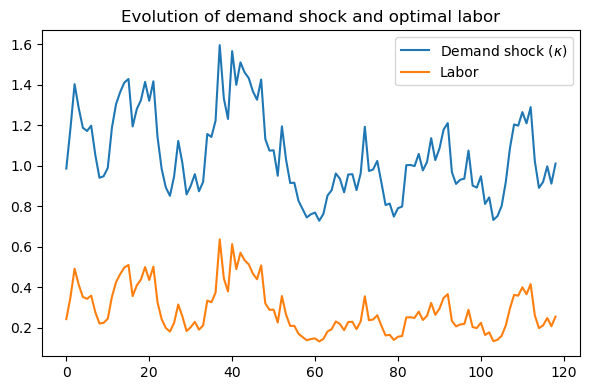

In [12]:
# a. plotting figure
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# b. adding plots
ax.plot(sim.kappa,label='Demand shock $(\kappa)$') # kappa 
ax.plot(sim.l,label='Labor') # labor

# c. specifications
ax.legend(frameon=True)
ax.set_title('Evolution of demand shock and optimal labor')
fig.tight_layout()

Finding the average $H$, when simulating the model multiple times 

In [13]:
# a. simulate 1000 times
sol = model.simulate(K=1000,seed=seed)
sol2_H = sim.H # storing result

print(f'the average H is {sim.H:.2f} using {sim.K} simulations')

the average H is 31.92 using 1000 simulations


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

Finding the average $H$, when simulating 100 times ande $\Delta$ is 0.05 

In [14]:
# a. simulating 100 times where delta is 0.05
sol3 = model.simulate(K=100, delta=0.05,seed=seed)

print(f'the average H is {sim.H:.2f} using {sim.K} simulation(s) where delta is {sim.delta}' )

# b. is the policy better
if sol3.H > sol2_H:
    print(f'as {sol3.H:.2f} > {sol2_H:.2f}, we see that the policy improves profitability')
else:
    print(f'as {sol3.H:.2f} < {sol2_H:.2f}, we see that the policy does not improves profitability')

the average H is 32.49 using 100 simulation(s) where delta is 0.05
as 32.49 > 31.92, we see that the policy improves profitability


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

Calculating optimal values using simple approach

In [15]:
# a. value function to optimize
vH = lambda x: -(model.simulate(K=100,delta=x,seed=seed).H)

# b. optimal value
np.random.seed(50)
opt_delta = optimize.minimize(vH, [0.01], method='nelder-mead',bounds=[(0,0.2)]).x[0]

print(f'the optimal delta is {opt_delta:.3f}')

the optimal delta is 0.010


The issue with the above approach is, that it is unable to properly capture the optimal value, as the function is very volatile with frequent changes in direction. This results in the optimal value often being very close to the initial guess. One solution is to try many initial guesses.

We try this below with a simple multistart optimizer. You can add more initial guesses if to increase accuracy at the cost of speed.

In [16]:
# optimal delta with 10 different initial guesses
sol = model.optimizer(vH,n_guess=10,K=100,seed=seed,do_print=False)

best, best_delta, best_H = sol[0], sol[1], sol[2]

print(f'optimal delta={best_delta:.3f} with H={best_H:.3f}')

optimal delta=0.144 with H=32.503


Plotting result showing optimal delta

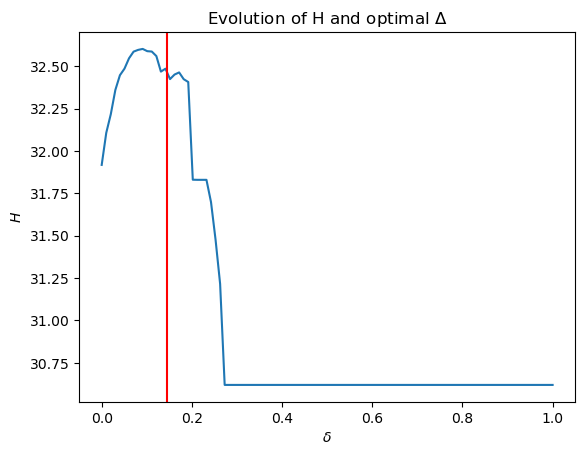

In [17]:
# a. setup
ticks = 100
delta_values = np.linspace(0,1,ticks)   
H_values = np.zeros((1,ticks))

# b. simulating
for i,x in enumerate(delta_values):
    H_values[0,i] = model.simulate(K=100, delta=x,seed=seed).H

# c. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(delta_values,H_values[0])
ax.set_xlabel(r'$\delta$') 
ax.set_ylabel(r'$H$')
plt.title(r'Evolution of H and optimal $\Delta$')
# d. inserts line with optimal delta
plt.axvline(x=best_delta,color='red')

Unfortunately the optimal $\Delta$ is largely dependent on the drawn seed due to the stochastic process of the demand shock. 

One way to deal with this, is to find the average optimal value of $\Delta$ when simulating the model with multiple seeds. We attempt this below with 5 randomly drawn seeds. More seeds increases the average accuracy at the cost of speed.

In [18]:
# a. seeds
seeds = 5

# b. setup
opt = np.zeros((2,seeds))

# c. optimal delta with different seeds and 5 guesses
for x in range(seeds):
    
    new_seed = np.random.randint(0,1000)
    sol = model.optimizer(vH,n_guess=5,K=100,seed=new_seed)

    opt[0,x] = sol[1] # optimal delta
    opt[1,x] = sol[2] # optimal H

# d. average optimal
avg_delta = np.average(opt[0])
avg_H = np.average(opt[1])

print(f'average optimal delta={avg_delta:.3f} with H={avg_H:.3f}')        

average optimal delta=0.132 with H=25.748


We can now illustrate the average optimal value of $\Delta$, using a random draw of $H$ for given values of $\Delta$ as backdrop. 

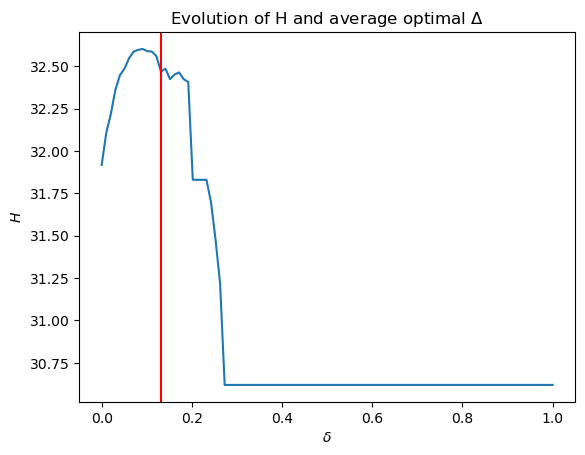

In [19]:
# a. plot (H is drawn from random seed) 
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(delta_values,H_values[0])
ax.set_xlabel(r'$\delta$') 
ax.set_ylabel(r'$H$')
plt.title(r'Evolution of H and average optimal $\Delta$')

# b. inserts line with optimal delta
plt.axvline(x=avg_delta,color='red')


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



We suggest the following anternative policy:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if } \Pi_t(\ell_{t-1}) < \Pi_t(\ell_t^{\ast}) - \iota\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\
\\
\text{and}\,\,\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t

$$

The intuition is, that if the hiring/firing yields higher profit after the cost of hiring/firing is accounted for, then the firm should should hire/fire.  

We execute the alternative policy below, by simulating 100 the difference in $H$ 100 times, and then seeing if the alternative policy is more likely to improve profit.

In [20]:
# a. setup
count = 100
succes = 0
sol_difference = np.zeros(count)

# b. loop simulation 
for i in range(count):

    # i. draw random seed
    seed = np.random.randint(0,1000)
    
    # ii. simulating where delta is average optimal delta
    sol = model.simulate(K=100,delta=avg_delta,seed=seed,extension=False).H
    sol_delta = sol

    # iii. simulating with alternative policy
    sol = model.simulate(K=100,seed=seed,extension=True).H
    sol_ext = sol

    # iv. count if alternative is better
    if sol_ext > sol_delta:
        succes += 1

    # v. differences
    sol_difference[i] = sol_ext - sol_delta

# c. average difference
avg_diff = np.average(sol_difference)

print(f'the alternative policy is better {succes}/{count} times, \nwith the average improvement in profit: {avg_diff:.3f}')

the alternative policy is better 83/100 times, 
with the average improvement in profit: 0.163


In general the alternative policy improves profit approximately 2/3 times, but this depends on the random draw of seed.

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also has a lot of **local minima**.

In [21]:
def griewank(x):
    return griewank_(x[0],x[1])
    
def griewank_(x1,x2):
    A = x1**2/4000 + x2**2/4000
    B = np.cos(x1/np.sqrt(1))*np.cos(x2/np.sqrt(2))
    return A-B+1

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

In [26]:
# a. run optimizer
sol = model.global_optimizer(griewank,10,1000,do_print=True)

print(f'the optimal optimal value for x is: \n x1 = {sol[0]:.3f} and x2 = {sol[1]:.3f}')

iteration 0: updating optimal value... x1 = -467.861 and x2 = -66.575
iteration 1: updating optimal value... x1 = 3.140 and x2 = -448.275
iteration 2: updating optimal value... x1 = -200.959 and x2 = -275.180
iteration 5: updating optimal value... x1 = 248.061 and x2 = 110.960
iteration 10: updating optimal value... x1 = 28.260 and x2 = 137.592
iteration 14: updating optimal value... x1 = 87.921 and x2 = 53.261
iteration 20: updating optimal value... x1 = -6.280 and x2 = 26.631
iteration 70: updating optimal value... x1 = 15.700 and x2 = 4.438
iteration 115: updating optimal value... x1 = -9.420 and x2 = 4.438
iteration 209: updating optimal value... x1 = -3.140 and x2 = 4.438
iteration 221: updating optimal value... x1 = 3.140 and x2 = -4.438
iteration 294: updating optimal value... x1 = -3.140 and x2 = 4.438
iteration 371: updating optimal value... x1 = -0.000 and x2 = -0.000
[-2.39553152e-09 -2.07564873e-09]
the optimal optimal value for x is: 
 x1 = -0.000 and x2 = -0.000


**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

In order to figure out if $\underline{K} = 100$ is faster, we run 10 loops of each using the optimizer, and calculate the average time it uses to find the optimum, and whether it found the global optimimum.

In [27]:
# a. setup
loops = 10
timer = np.zeros((2,loops))
K_list = [10,100] # K_ values to check
all_found_optimum = True

# b. loop through K_ values
for i,K_ in enumerate(K_list):

    # 1. loops to optimize
    for x in range(loops):

        # i. timing optimizer
        t0 = time.time()
        sol = model.global_optimizer(griewank,K_,1000)
        t1 = time.time()
        timer[i,x] = t1-t0

        # ii. found optimum?
        all_found_optimum = np.allclose(sol,[0,0],atol=10**(-6))

    # 2. calculating average time
    average_time = np.average(timer[i])

    print(f'K_ = {K_}: average time: {average_time:.3f} seconds \n  all iterations found optimum: {all_found_optimum}' )

K_ = 10: average time: 0.988 seconds 
  all iterations found optimum: True
K_ = 100: average time: 1.198 seconds 
  all iterations found optimum: True


Increasing $\underline{K}$ gave a slower convergence. The above is not surprising. When deciding the amount of warm-up iterations you have a tradeoff between speed and risk of not finding the global optimum. A higher amount of warm-up iterations means you examine more of the area inbetween the bounds, as such the probability of not finding the global optimum decreases. If the number of warm-up iterations is low you begin optimizing the starting value faster, but run a higher risk of not finding the global optimum.